### <font color='red'>AI004 - Explore Two Appropriate Models and Train</font>
### <font color='red'>AI005 - Create Evaluation Visualizations</font>


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import plotly.express as px
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import nltk

### Data Preparation

In [2]:
#data source: https://huggingface.co/datasets/md_gender_bias
train_data = pd.read_json('data/md_gender_bias/funpedia/train.jsonl', lines = True)
test_data = pd.read_json('data/md_gender_bias/funpedia/test.jsonl', lines = True)
val_data = pd.read_json('data/md_gender_bias/funpedia/valid.jsonl', lines = True)

#combine pre-split datasets into one then apply train test split function twice
unified_data = train_data.append(test_data, ignore_index=True)
unified_data = unified_data.append(val_data, ignore_index=True)
print('nrows raw unified dataset:', len(unified_data))


#drop all columns except text and label
unified_data = unified_data[['text', 'gender']]

#ensure all text lowercase so can compare for duplicates
for col in ['text', 'gender']:
    unified_data[col] = unified_data[col].str.lower()
    
#check duplicate rows in 'text' column
print('Number of duplicates:', len(unified_data[unified_data.duplicated(['text'])]))
#drop duplicates
unified_data.drop_duplicates(subset=['text'], inplace = True)
#recheck number of duplicates
print('Number of duplicates:', len(unified_data[unified_data.duplicated(['text'])]))


#drop NAs
unified_data.dropna(inplace = True)

#drop 'gender-neutral' class?
unified_data = unified_data[unified_data['gender'] != 'gender-neutral']


#downsample 'male' to fix class imbalance
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority', random_state= 0)
X = np.array(unified_data['text']).reshape(-1, 1)
y = np.array(unified_data['gender']).reshape(-1, 1)
X_undersample, y_undersample = undersample.fit_resample(X, y)

#flatten to 1D array in order to reocmbine into a new undersampled 'unified_data' dataframe
X_undersample = X_undersample.flatten()
y_undersample = y_undersample.flatten()

unified_data = pd.DataFrame({'text': X_undersample, 'gender': list(y_undersample)}, columns=['text', 'gender'])


#convert two classes to new binary id column
unified_data['gender_id'] = unified_data['gender']
unified_data['gender_id'].replace(['male', 'female'], [0, 1], inplace = True)
print(unified_data[unified_data['gender'] == 'male'].head(3))
print(unified_data[unified_data['gender'] == 'female'].head(3))


#import sklearn stop words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = list(ENGLISH_STOP_WORDS)
my_stop_words = stop_words.copy()

#to add stop words, e.g.
#my_stop_words = text.ENGLISH_STOP_WORDS.union(["book"])

#word_remove = ['he', 'she', 'him', 'her', 'hers', 'his', 'himself', 'herself']
word_remove = []
for i in my_stop_words:
    if i in word_remove:
        my_stop_words.remove(i)

my_stop_words = frozenset(my_stop_words)


from nltk.tokenize import word_tokenize   #requires nltk.download('punkt') but SSL cert error
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist

#regex here already removes punctuation
#regex here includes tokens that have at least one letter, removing numbers from consideration (can be used in token_pattern argument too)
regexp = RegexpTokenizer(u'(?ui)\\b\\w*[a-z]+\\w*\\b')
unified_data['text_token']=unified_data['text'].apply(regexp.tokenize)

#remove stopwords
unified_data['text_token'] = unified_data['text_token'].apply(lambda x: [item for item in x if item not in my_stop_words])

#keep only words longer than 1 character
unified_data['text_string'] = unified_data['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>1]))
unified_data['text_token'] = unified_data['text_token'].apply(lambda x: [item for item in x if len(item)>1])

#create list of all words
all_words = ' '.join([word for word in unified_data['text_string']])
tokenized_words = word_tokenize(all_words)

#create a frequency distribution which records the number of times each word has occurred:
fdist = FreqDist(tokenized_words)
fdist


#stemming
from nltk.stem.snowball import SnowballStemmer
#use English stemmer
stemmer = SnowballStemmer("english")
unified_data['stemmed'] = unified_data['text_token'].apply(lambda x: ' '.join([stemmer.stem(y) for y in x]))

#prep for word cloud
all_words_stem = ' '.join([word for word in unified_data['stemmed']])
print(all_words_stem[0:1000])
tokenized_words_new = word_tokenize(all_words_stem)

#simplify dataframe
unified_data = unified_data[['stemmed', 'gender_id', 'gender']]
print(unified_data.head(3))


#vectorizing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf = TfidfVectorizer(max_features = 10000, 
                        max_df=0.5, 
                        encoding='utf-8', 
                        ngram_range=(1, 3), 
                        stop_words=None,   #already done above
                        lowercase = True,   #already done above
                        token_pattern = u'(?ui)\\b\\w*[a-z]+\\w*\\b',   #same as before
                        use_idf = True)

X = tfidf.fit_transform(unified_data['stemmed']).toarray()
y = unified_data['gender_id']


#splitting into train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2) 

print('percentage data that is TRAIN:', round((len(X_train)/len(unified_data))*100, 2))
print('percentage data that is TEST:', round((len(X_test)/len(unified_data))*100, 2))

/var/folders/70/yx3rlp812k545ncgsfplvcbc0000gn/T/ipykernel_1997/1338563936.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unified_data = train_data.append(test_data, ignore_index=True)
/var/folders/70/yx3rlp812k545ncgsfplvcbc0000gn/T/ipykernel_1997/1338563936.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unified_data = unified_data.append(val_data, ignore_index=True)


nrows raw unified dataset: 29819
Number of duplicates: 1
Number of duplicates: 0
                                                   text gender  gender_id
4457  holy moly! josh brown guest starred in the sho...   male          0
4458  jim colver has been serving the residents of a...   male          0
4459  born in cleveland, ford was luckily taken by t...   male          0
                                                text  gender  gender_id
0   danielle frenkel is a high jumper born in israel  female          1
1  tania mihailuk is a politician who was born in...  female          1
2  juliet taylor is a woman who works as a castin...  female          1
daniell frenkel high jumper born israel tania mihailuk politician born australia juliet taylor woman work cast director margaret carolin rudd born britain notori femal forger retta scott american artist die cice mari barker fantasi illustr depict fairi flower che zahara work malay activist fought hard women children right singapor fe

### Define baseline model - XGBoost

In [3]:
import xgboost as xgb
from xgboost import XGBClassifier

#define baseline model
model_xgb = XGBClassifier(max_depth = 5, random_state = 0, verbosity = 1, objective = 'binary:logistic', n_jobs = -1)

### Grid search hyperparameters (learning_rate and n_estimators) using K-Fold Cross-Validation - XGBoost

In [4]:
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.model_selection import GridSearchCV

#grid search
def evaluate_model(cross_val):
    learning_rate = [0.1, 0.2, 0.3]
    n_estimators = [5]   #set to 5 to speed up, 100 is optimum
    param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
    grid_search = GridSearchCV(model_xgb, param_grid, scoring="accuracy", cv=cross_val, n_jobs=-1, verbose = 0)
    grid_result = grid_search.fit(X_train, y_train)
    
    #summarize performance
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [5]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

k = 2
folds = range(1, k+1)

for fold_num in tqdm(folds):
	#define test condition
	cross_val = KFold(n_splits=k, random_state=0, shuffle=True)

	evaluate_model(cross_val)
	print('> folds=%d' % (fold_num))

  0%|          | 0/2 [00:00<?, ?it/s]

Best: 0.592764 using {'learning_rate': 0.3, 'n_estimators': 5}
0.581406 (0.004569) with: {'learning_rate': 0.1, 'n_estimators': 5}
0.585893 (0.000082) with: {'learning_rate': 0.2, 'n_estimators': 5}
0.592764 (0.001626) with: {'learning_rate': 0.3, 'n_estimators': 5}
> folds=1
Best: 0.592764 using {'learning_rate': 0.3, 'n_estimators': 5}
0.581406 (0.004569) with: {'learning_rate': 0.1, 'n_estimators': 5}
0.585893 (0.000082) with: {'learning_rate': 0.2, 'n_estimators': 5}
0.592764 (0.001626) with: {'learning_rate': 0.3, 'n_estimators': 5}
> folds=2


### Fit finalised model - XGBoost

In [6]:
#define finalised model
model_xgb = XGBClassifier(n_estimators = 5, max_depth = 5, random_state = 0, verbosity = 1, learning_rate = 0.3, objective = 'binary:logistic', n_jobs = -1)

#fit model to training data
model_xgb.fit(X_train, y_train)

#make predictions for test data
y_pred = model_xgb.predict(X_test)
y_pred = [round(value) for value in y_pred]

### Evaluation visualisations - XGBoost

Accuracy: 60.572%
              precision    recall  f1-score   support

      female       0.97      0.22      0.35       888
        male       0.56      0.99      0.72       895

    accuracy                           0.61      1783
   macro avg       0.77      0.60      0.53      1783
weighted avg       0.76      0.61      0.54      1783



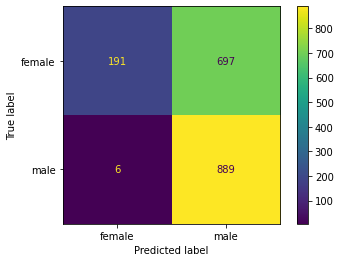

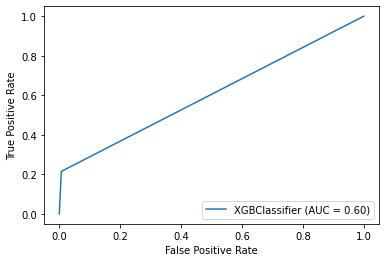

In [7]:
# evaluate predictions
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc, plot_roc_curve, RocCurveDisplay

y_test_alt = pd.Series(y_test)
y_test_alt.replace(0, 'male', inplace = True)
y_test_alt.replace(1, 'female', inplace = True)
y_pred_alt = pd.Series(y_pred)
y_pred_alt.replace(0, 'male', inplace = True)
y_pred_alt.replace(1, 'female', inplace = True)

accuracy = accuracy_score(y_test, y_pred)

print('Accuracy: %.3f%%' % (accuracy * 100.0))

print(classification_report(y_test_alt, y_pred_alt))
ConfusionMatrixDisplay.from_predictions(y_test_alt, y_pred_alt)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBClassifier')
display.plot()
plt.show()

### Define baseline model - Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
model_nb = MultinomialNB()

### Grid search hyperparameters (alpha) using K-Fold Cross-Validation - Naive Bayes

In [9]:
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.model_selection import GridSearchCV

#grid search
def evaluate_model(cross_val):

    alpha = [0, 0.5, 1, 1.5, 2, 2.5, 3]
    param_grid = dict(alpha=alpha)
    grid_search = GridSearchCV(model_nb, param_grid, scoring="accuracy", cv=cross_val, n_jobs=-1, verbose = 0)
    grid_result = grid_search.fit(X_train, y_train)
    
    #summarize performance
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [10]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

k = 2
folds = range(1, k+1)

for fold_num in tqdm(folds):
	#define test condition
	cross_val = KFold(n_splits=k, random_state=0, shuffle=True)

	evaluate_model(cross_val)
	print('> folds=%d' % (fold_num))


  0%|          | 0/2 [00:00<?, ?it/s]

/Users/joshua.grefte/Library/Python/3.10/lib/python/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/joshua.grefte/Library/Python/3.10/lib/python/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Best: 0.732435 using {'alpha': 1}
0.680691 (0.006827) with: {'alpha': 0}
0.731174 (0.001019) with: {'alpha': 0.5}
0.732435 (0.003684) with: {'alpha': 1}
0.731454 (0.003543) with: {'alpha': 1.5}
0.730893 (0.002983) with: {'alpha': 2}
0.729210 (0.005507) with: {'alpha': 2.5}
0.727667 (0.005648) with: {'alpha': 3}
> folds=1


/Users/joshua.grefte/Library/Python/3.10/lib/python/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/joshua.grefte/Library/Python/3.10/lib/python/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Best: 0.732435 using {'alpha': 1}
0.680691 (0.006827) with: {'alpha': 0}
0.731174 (0.001019) with: {'alpha': 0.5}
0.732435 (0.003684) with: {'alpha': 1}
0.731454 (0.003543) with: {'alpha': 1.5}
0.730893 (0.002983) with: {'alpha': 2}
0.729210 (0.005507) with: {'alpha': 2.5}
0.727667 (0.005648) with: {'alpha': 3}
> folds=2


### Fit finalised model - Naive Bayes

In [11]:
model_nb = MultinomialNB(alpha = 1)

In [12]:
#fit model to training data
model_nb.fit(X_train, y_train)

#make predictions for test data
y_pred = model_nb.predict(X_test)
y_pred = [round(value) for value in y_pred]

### Evaluation visualisations - Naive Bayes

Accuracy: 79.361%
              precision    recall  f1-score   support

      female       0.79      0.80      0.79       888
        male       0.80      0.79      0.79       895

    accuracy                           0.79      1783
   macro avg       0.79      0.79      0.79      1783
weighted avg       0.79      0.79      0.79      1783



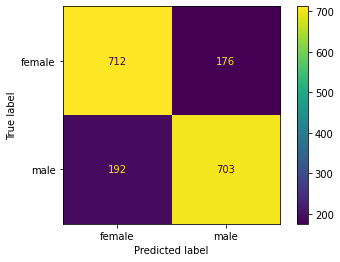

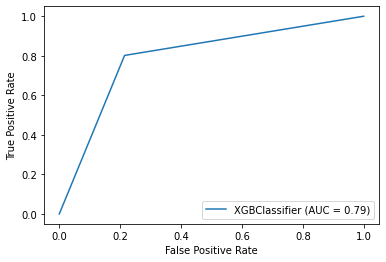

In [13]:
# evaluate predictions
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc, plot_roc_curve, RocCurveDisplay

y_test_alt = pd.Series(y_test)
y_test_alt.replace(0, 'male', inplace = True)
y_test_alt.replace(1, 'female', inplace = True)
y_pred_alt = pd.Series(y_pred)
y_pred_alt.replace(0, 'male', inplace = True)
y_pred_alt.replace(1, 'female', inplace = True)

accuracy = accuracy_score(y_test, y_pred)

print('Accuracy: %.3f%%' % (accuracy * 100.0))

print(classification_report(y_test_alt, y_pred_alt))
ConfusionMatrixDisplay.from_predictions(y_test_alt, y_pred_alt)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBClassifier')
display.plot()
plt.show()